In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

%matplotlib inline

In [3]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

data = pd.read_csv('../data/delaney.csv')

data.head()

test = data.sample(frac=0.2, random_state=0)
train = data[~data.index.isin(test.index)]

1.12.0
2.2.4


Using TensorFlow backend.


In [4]:
from sklearn.preprocessing import StandardScaler

y_train = train['measured log solubility in mols per litre'].values.reshape(-1, 1)
y_test = test['measured log solubility in mols per litre'].values.reshape(-1, 1)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [5]:
from nfp.preprocessing import SmilesPreprocessor, GraphSequence
from nfp.preprocessing import features

In [6]:
preprocessor = SmilesPreprocessor(explicit_hs=False)

inputs_train = preprocessor.fit(train.smiles)
inputs_test = preprocessor.predict(test.smiles)

batch_size = 50
train_generator = GraphSequence(inputs_train, y_train_scaled, batch_size)
test_generator = GraphSequence(inputs_test, y_test_scaled, batch_size)

100%|██████████| 226/226 [00:00<00:00, 2171.86it/s]


In [7]:
len(train_generator[2][0]['bond'])

1238

In [8]:
len(train_generator[1][0]['bond'])

1400

In [9]:
import warnings

# Define Keras model
import keras
import keras.backend as K

from keras.layers import (
    Input, Embedding, Dense, BatchNormalization, Reshape, Lambda, Activation)

from keras.models import Model
from keras.engine import Layer

from nfp.layers import GRUStep, ReduceAtomToMol, Embedding2D, Squeeze, MessageLayer
from nfp.models import GraphModel

In [10]:
# Raw (integer) graph inputs
node_graph_indices = Input(shape=(1,), name='node_graph_indices', dtype='int32')
atom_types = Input(shape=(1,), name='atom', dtype='int32')
bond_types = Input(shape=(1,), name='bond', dtype='int32')
connectivity = Input(shape=(2,), name='connectivity', dtype='int32')

squeeze = Squeeze()

snode_graph_indices = squeeze(node_graph_indices)
satom_types = squeeze(atom_types)
sbond_types = squeeze(bond_types)

# Initialize RNN and MessageLayer instances
atom_features = 20

# Initialize the atom states
atom_state = Embedding(
    preprocessor.atom_classes,
    atom_features, name='atom_embedding')(satom_types)

# Initialize the bond states
bond_matrix = Embedding2D(
    preprocessor.bond_classes,
    atom_features, name='bond_embedding')(sbond_types)

atom_rnn_layer = GRUStep(atom_features)
message_layer = MessageLayer(reducer='sum', dropout=0.1)

message_steps = 3
# Perform the message passing
for _ in range(message_steps):

    # Get the message updates to each atom
    message = message_layer([atom_state, bond_matrix, connectivity])

    # Update memory and atom states
    atom_state = atom_rnn_layer([message, atom_state])
    
atom_state = BatchNormalization(momentum=0.9)(atom_state)
atom_fingerprint = Dense(64, activation='sigmoid')(atom_state)
atom_fingerprint = BatchNormalization(momentum=0.9)(atom_fingerprint)

mol_fingerprint = ReduceAtomToMol(reducer='sum')([atom_fingerprint, snode_graph_indices])

out = Dense(1)(mol_fingerprint)
model = GraphModel([node_graph_indices, atom_types, bond_types, connectivity], [out])
model.compile(optimizer=keras.optimizers.Adam(lr=1E-4), loss='mse')
model.summary()

Model: "graphmodel_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
bond (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
squeeze_1 (Squeeze)             (None,)              0           node_graph_indices[0][0]         
                                                                 atom[0][0]                       
                                                                 bond[0][0]                       
_______________________________________________________________________________________

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    hist = model.fit_generator(train_generator, validation_data=test_generator, epochs=50, verbose=2)

Epoch 1/50
 - 2s - loss: 14.2709 - val_loss: 7.4464
Epoch 2/50
 - 0s - loss: 4.7392 - val_loss: 3.5310
Epoch 3/50
 - 0s - loss: 2.3454 - val_loss: 2.3483
Epoch 4/50
 - 0s - loss: 1.5226 - val_loss: 1.7112
Epoch 5/50
 - 0s - loss: 1.1399 - val_loss: 1.4239
Epoch 6/50
 - 0s - loss: 0.9128 - val_loss: 1.1788
Epoch 7/50
 - 0s - loss: 0.8064 - val_loss: 0.9838
Epoch 8/50
 - 0s - loss: 0.6848 - val_loss: 0.8991
Epoch 9/50
 - 0s - loss: 0.5957 - val_loss: 0.7659
Epoch 10/50
 - 0s - loss: 0.5237 - val_loss: 0.6798
Epoch 11/50
 - 0s - loss: 0.5978 - val_loss: 0.6439
Epoch 12/50
 - 0s - loss: 0.5380 - val_loss: 0.5641
Epoch 13/50
 - 0s - loss: 0.5840 - val_loss: 0.5064
Epoch 14/50
 - 0s - loss: 0.4010 - val_loss: 0.4803
Epoch 15/50
 - 0s - loss: 0.3814 - val_loss: 0.4583
Epoch 16/50
 - 0s - loss: 0.4385 - val_loss: 0.4233
Epoch 17/50
 - 0s - loss: 0.3728 - val_loss: 0.3979
Epoch 18/50
 - 0s - loss: 0.3207 - val_loss: 0.3685
Epoch 19/50
 - 0s - loss: 0.3185 - val_loss: 0.3718
Epoch 20/50
 - 0s - 

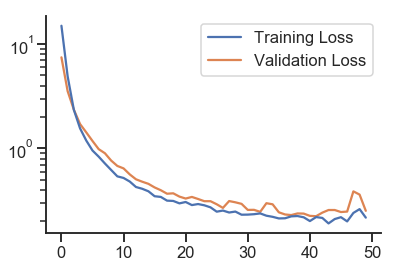

In [12]:
plt.semilogy(hist.history['loss'], label='Training Loss')
plt.semilogy(hist.history['val_loss'], label='Validation Loss', zorder=0)

plt.legend(loc='upper right')
sns.despine()

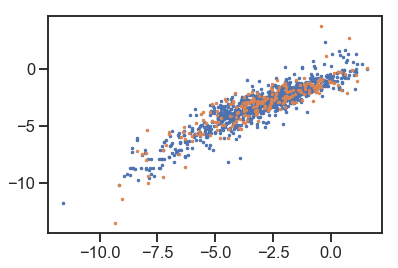

In [13]:
y_train_pred = y_scaler.inverse_transform(
    model.predict_generator(GraphSequence(inputs_train, batch_size=32, shuffle=False)))
y_test_pred = y_scaler.inverse_transform(
    model.predict_generator(GraphSequence(inputs_test, batch_size=32, shuffle=False)))

plt.plot(y_train, y_train_pred, '.', ms=5)
plt.plot(y_test, y_test_pred, '.', ms=5)

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
model.evaluate_generator(test_generator)

0.25273634717527743

In [18]:
model.save('test.h5')

from keras.models import load_model
from nfp import custom_layers

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = load_model('test.h5', custom_objects=custom_layers)

model.evaluate_generator(test_generator)

0.25273634717527743

In [ ]:
# atom_layers = K.Function([atom_types, connectivity], atom_states)
# atoms = atom_layers(inputs_train)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca.fit(np.vstack([atom[atom_train != 0] for atom in atoms]))

# fig, axmatrix = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(15, 3.5))

# for ax, atom in zip(axmatrix.flatten(), atoms):
    
#     x, y = pca.transform(atom[atom_train != 0]).T
#     ax.scatter(x, y, s=5, c=atom_train[atom_train != 0], cmap='gist_ncar', alpha=0.1)
    
# for i, ax in enumerate(axmatrix.flatten()):
#     ax.set_title('Atom Layer {}'.format(i))

In [ ]:
# mol_layers = K.Function([atom_types, connectivity], [fingerprint])
# mols = mol_layers(inputs_train)[0]

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca.fit(np.vstack(mols))
# x, y = pca.transform(mols).T    
# plt.scatter(x, y, s=20, c=y_train[:, 0], cmap='coolwarm')